In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
%matplotlib inline

In [203]:
#Required text pre-processing libraries are imported
import string
import nltk
import re

# download the stopwords and wordnet corpus
nltk.download('stopwords')
from nltk.corpus import stopwords
# import tokenize from nltk library
from nltk import tokenize
# import WordNetLemmatizer from nltk library
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from sklearn.feature_extraction.text import CountVectorizer
from nltk.probability import FreqDist

#Required data visualisation libraries are imported
import plotly.express as px
import seaborn as sns 
import matplotlib.pyplot as plt


#Required prediction modelling libraries are imported
from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.metrics import plot_confusion_matrix, confusion_matrix, precision_recall_curve, auc, roc_curve, accuracy_score, recall_score, classification_report, f1_score, precision_score, precision_recall_fscore_support, roc_auc_score, make_scorer
from sklearn.pipeline import Pipeline

from imblearn.over_sampling import SMOTE
#from imblearn.over_sampling import SMOTEN
from imblearn.pipeline import Pipeline as ImPipeline

import xgboost
from xgboost import XGBClassifier

import pickle
import json


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jillian/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/jillian/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /Users/jillian/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/jillian/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


ImportError: cannot import name 'SMOTEN' from 'imblearn.over_sampling' (/Users/jillian/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/over_sampling/__init__.py)

In [94]:
#reading in final dataset cleaned with additional stop words

In [18]:
df = pd.read_csv('./data/single_word_data.csv')

In [19]:
df.head()

,Clothing_ID,Age,Title,Review_Text,Rating,Recommended_IND,Positive_Feedback_Count,Division_Name,Department Name,Class_Name,Clean,String,Positive_Rating
0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates,"['absolutely', 'wonderful', 'silky', 'sexy', '...",absolutely wonderful silky sexy comfortable,1
1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses,"['sooo', 'pretty', 'happened', 'find', 'store'...",sooo pretty happened find store glad bc never ...,1
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses,"['high', 'hope', 'wanted', 'work', 'initially'...",high hope wanted work initially petite usual f...,0
3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants,"['jumpsuit', 'fun', 'flirty', 'fabulous', 'eve...",jumpsuit fun flirty fabulous every time get no...,1
4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses,"['shirt', 'flattering', 'due', 'adjustable', '...",shirt flattering due adjustable front tie perf...,1


In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22636 entries, 0 to 22635
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Clothing_ID              22636 non-null  int64 
 1   Age                      22636 non-null  int64 
 2   Title                    19674 non-null  object
 3   Review_Text              22636 non-null  object
 4   Rating                   22636 non-null  int64 
 5   Recommended_IND          22636 non-null  int64 
 6   Positive_Feedback_Count  22636 non-null  int64 
 7   Division_Name            22623 non-null  object
 8   Department Name          22623 non-null  object
 9   Class_Name               22623 non-null  object
 10  Clean                    22636 non-null  object
 11  String                   22636 non-null  object
 12  Positive_Rating          22636 non-null  int64 
dtypes: int64(6), object(7)
memory usage: 2.2+ MB


In [21]:
df.isna().sum()

Clothing_ID                   0
Age                           0
Title                      2962
Review_Text                   0
Rating                        0
Recommended_IND               0
Positive_Feedback_Count       0
Division_Name                13
Department Name              13
Class_Name                   13
Clean                         0
String                        0
Positive_Rating               0
dtype: int64

In [98]:
df2 = pd.read_csv('./data/bigram_data.csv')

In [99]:
df2.head()

,Age,Class_Name,Clothing_ID,Department Name,Division_Name,Positive_Feedback_Count,Rating,Recommended_IND,Title,Review_Text,Polarity,Subjective,Clean,String,Polarity_Clean,Subjective_Clean,Positive_Rating
0,33,Intimates,767,Intimate,Initmates,0,4,1,NaN,Absolutely wonderful - silky and sexy and comf...,0.633333,0.933333,"['absolutely', 'wonderful', 'silky', 'sexy', '...",absolutely wonderful silky sexy comfortable,0.633333,0.933333,1
1,34,Dresses,1080,Dresses,General,4,5,1,NaN,Love this dress! it's sooo pretty. i happene...,0.339583,0.725000,"['love', 'dress', 'sooo', 'pretty', 'happened'...",love dress sooo pretty happened find store im ...,0.318750,0.725000,1
2,60,Dresses,1077,Dresses,General,0,3,0,Some major design flaws,I had such high hopes for this dress and reall...,0.073675,0.356294,"['high', 'hope', 'dress', 'really', 'wanted', ...",high hope dress really wanted work initially o...,0.079865,0.349762,0
3,50,Pants,1049,Bottoms,General Petite,0,5,1,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",0.550000,0.625000,"['love', 'love', 'love', 'jumpsuit', 'fun', 'f...",love love love jumpsuit fun flirty fabulous ev...,0.500000,0.625000,1
4,47,Blouses,847,Tops,General,6,5,1,Flattering shirt,This shirt is very flattering to all due to th...,0.512891,0.568750,"['shirt', 'very', 'flattering', 'due', 'adjust...",shirt very flattering due adjustable front tie...,0.393750,0.568750,1


In [100]:
df2.isna().sum()

Age                           0
Class_Name                   13
Clothing_ID                   0
Department Name              13
Division_Name                13
Positive_Feedback_Count       0
Rating                        0
Recommended_IND               0
Title                      2965
Review_Text                   0
Polarity                      0
Subjective                    0
Clean                         0
String                        0
Polarity_Clean                0
Subjective_Clean              0
Positive_Rating               0
dtype: int64

# Modeling

In [22]:
#will be using accuracy as metric; want to identify neutral/negative sentiments and be able
#to sample enough of them to get a clear view of if there is a consistent issue
#that we as a company can change for our soft roll out
#also want to be able to ball park which items will be most popular, so we can have
#an appropriate amount of inventory

For each model we created a pipeline that includes a TF-IDF vectorizer, a smote component to deal with class imbalance, and the classifier itself. We elected to use a TF-IDF vectorizer instead of a count vectorizer because it provides a way to understand the importance of each word to the tweet, as well as just how frequently it occurs.

To give the model a little bit more information with those same features, we'll use a TfidfVectorizer (documentation here) so that it counts not only the term frequency (tf) within a single document, it also includes the inverse document frequency (idf) — how rare the term is.



### Train-Test Split With df

In [23]:
# Specify X as the cleaned strings in df and y as the target-Positive_Rating.
X = df['String']
y = df['Positive_Rating']

In [24]:
#Performed the train-test split, using 20% for the hold-out data.
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    random_state=42,
                                                    test_size=0.20)

In [25]:
X_train

19634    always lookout piece polished arent fussy blaz...
12704    short linen touch stretch great keeping shape ...
9195     wanted sweater lavender design pleated back be...
4688               glad tried see lovely definitely keeper
21451    got fooled description polyester wool claim ch...
                               ...                        
11964    great work enjoying brunch dinner friend comfo...
21575    cozy wrap material soft find grabbing anytime ...
5390     duster nice light weight dark navy throw add l...
860      excited see jean since came petite short insea...
15795    sweater pretty soft real life purchase coral r...
Name: String, Length: 18108, dtype: object

In [26]:
# Instantiate a vectorizer 
# Instantiate and fit/transform X_train using the TF-IDF vectorizer.
tfidf = TfidfVectorizer()
X_train_vectorized = tfidf.fit_transform(X_train)
X_train_vectorized

<18108x15448 sparse matrix of type '<class 'numpy.float64'>'
	with 409986 stored elements in Compressed Sparse Row format>

In [27]:
# Convert vectorized X_train to a vector for easier visual inspection.
X_train_vec = pd.DataFrame.sparse.from_spmatrix(X_train_vectorized, columns=tfidf.get_feature_names())
X_train_vec

/Users/jillian/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,00p,00p0p,00p0rxxsxs,02xs,03dd,0dd,0in,0p,0pand,0petite,...,zippered,zipperi,zippie,zipping,zombie,zone,zoolanders,zoom,zooming,zuma
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18103,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18104,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18105,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18106,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [28]:
# Transform test data using TF-IDF Vectorizer trained on X_train, y_train
X_test_vectorized = tfidf.transform(X_test)
X_test_vectorized

<4528x15448 sparse matrix of type '<class 'numpy.float64'>'
	with 98903 stored elements in Compressed Sparse Row format>

In [29]:
# Convert to DataFrame for visual inspection
X_test_vec = pd.DataFrame.sparse.from_spmatrix(X_test_vectorized, columns=tfidf.get_feature_names())
X_test_vec

/Users/jillian/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,00p,00p0p,00p0rxxsxs,02xs,03dd,0dd,0in,0p,0pand,0petite,...,zippered,zipperi,zippie,zipping,zombie,zone,zoolanders,zoom,zooming,zuma
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4523,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4524,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4525,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4526,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Train-Test Split With df2 (without additional stop words removed)

In [101]:
# Specify X as the cleaned strings in df and y as the target-Positive_Rating.
X2 = df2['String']
y2 = df2['Positive_Rating']

In [102]:
#Performed the train-test split, using 20% for the hold-out data.
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2,
                                                    y2,
                                                    random_state=42,
                                                    test_size=0.20)

In [103]:
X_train2

19805                   love contrast much prettier person
11396    top look better hanger ive looking feminine pl...
7884     wasnt much question whether id love pant sever...
21304    legging warm comfortable theyre thick enough w...
7216                     much lower quality robe purchased
                               ...                        
11964    bought grey gorgeous color like long length ar...
21575    dress really pretty fun see dress tone subtle ...
5390     bought one tee washed time luckily hole yet li...
860      wa excited see jean since came petite size sho...
15795              bought sweater love one favorite season
Name: String, Length: 18112, dtype: object

In [104]:
# Instantiate a vectorizer 
# Instantiate and fit/transform X_train using the TF-IDF vectorizer.
tfidf = TfidfVectorizer()
X_train_vectorized2 = tfidf.fit_transform(X_train2)
X_train_vectorized2

<18112x15411 sparse matrix of type '<class 'numpy.float64'>'
	with 489216 stored elements in Compressed Sparse Row format>

In [105]:
# Convert vectorized X_train to a vector for easier visual inspection.
X_train_vec2 = pd.DataFrame.sparse.from_spmatrix(X_train_vectorized2, columns=tfidf.get_feature_names())
X_train_vec2

/Users/jillian/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,002first,00p,00p0p,02xs,03dd,0dd,0p,0pand,0petite,0r,...,zipper,zippered,zipperi,zipperone,zipping,zombie,zone,zoom,zooming,zuma
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18107,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18108,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18109,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18110,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [106]:
# Transform test data using TF-IDF Vectorizer trained on X_train, y_train
X_test_vectorized2 = tfidf.transform(X_test2)
X_test_vectorized2

<4528x15411 sparse matrix of type '<class 'numpy.float64'>'
	with 118506 stored elements in Compressed Sparse Row format>

In [107]:
# Convert to DataFrame for visual inspection
X_test_vec2 = pd.DataFrame.sparse.from_spmatrix(X_test_vectorized2, columns=tfidf.get_feature_names())
X_test_vec2

/Users/jillian/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,002first,00p,00p0p,02xs,03dd,0dd,0p,0pand,0petite,0r,...,zipper,zippered,zipperi,zipperone,zipping,zombie,zone,zoom,zooming,zuma
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4523,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4524,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4525,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4526,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Function to return scores in cross validation

In [31]:
# Accuracy
accuracy = make_scorer(accuracy_score)

#f1
custom_f1 = make_scorer(
    f1_score, 
    average="weighted")

# Precision
multi_prec = make_scorer(
    precision_score,
    average="weighted")

# Recall
multi_rec = make_scorer(
    recall_score,
    average="weighted")

# This function will allow for quick cross-validation of the chosen score for each of our models.
def cross_val(model, X, y, custom_scorer, kfolds=5):
    """ Perform cross-validated scoring and store/print results """
    results = cross_val_score(model, X, y, cv=kfolds, scoring=custom_scorer)
    mean = np.mean(results)
    median = np.median(results)
    std = np.std(results)
    if custom_scorer == accuracy:
        print(f"Mean accuracy score: ", {mean}, ".")
        print(f"Median acuracy score: ", {median}, ".")
        print(f"Standard Deviation in accuracy: ", {std}, ".") 
    elif custom_scorer == custom_f1:
        print(f"Mean f1 score: ", {mean}, ".")
        print(f"Median f1 score: ", {median}, ".")
        print(f"Standard Deviation in f1 score: ", {std}, ".") 
    elif custom_scorer == multi_prec:
        print(f"Mean precision score: ", {mean}, ".")
        print(f"Median precision score: ", {median}, ".")
        print(f"Standard Deviation in precision score: ", {std}, ".") 
    elif custom_scorer == multi_rec:
        print(f"Mean recall score: ", {mean}, ".")
        print(f"Median recall score: ", {median}, ".")
        print(f"Standard Deviation in recall score: ", {std}, ".") 

## Dummy Classifier

0.7688866799204771


/Users/jillian/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


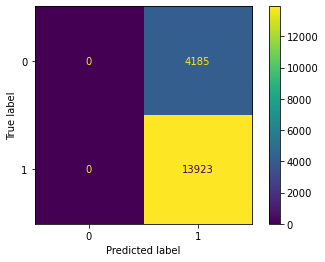

In [32]:
# Instantiate Dummy Classifier 
dummy_model = DummyClassifier()

#Fit and Evaluate Dummy Classifier
dummy_model.fit(X_train_vectorized, y_train)
dummy_yhat = dummy_model.predict(X_train)
plot_confusion_matrix(dummy_model, X_train, y_train);
print(accuracy_score(y_train, dummy_yhat))

We see our Dummy Model predicts our majority label, 1, for each observation. Due to class imbalance, the model performed well at 77% accuracy score.

## Multinomal Naive Bayes

Now that we have preprocessed data, we can fit and evaluate a multinomial Naive Bayes classifier using cross_val_score.

In [33]:
# Instantiate a MultinomialNB classifier
multinomial_model = MultinomialNB()

# Evaluate the classifier on X_train_vectorized and y_train
multinomial_cv = cross_val_score(multinomial_model, X_train_vectorized, y_train)
multinomial_cv

array([0.786582  , 0.7807841 , 0.78244064, 0.78376139, 0.78210439])

In [34]:
y_train.value_counts(normalize=True)

1    0.768887
0    0.231113
Name: Positive_Rating, dtype: float64

If we guessed the plurality class every time (class 1), we would expect about 77% accuracy score (captured by our Dummy Model). So when this model is getting 78% accuracy, that is a very minimal improvement over just guessing. Let's see if we can improve that with more sophisticated modeling techinques. 

In [35]:
#With no max_features set, we see X_train_vec and X_test_vec contains 15448 columns(unique words); this many words will create
#a lot of "noise"; we want to set our max_features to only focus on the words that are appearing more often
#setting max_features to 500 improved Multinomial NB to over 80%

## Initial Model CV Results

In [36]:
benchmark = []
# Iterate over all algorithms
for algorithm in [MultinomialNB(), LogisticRegression(), KNeighborsClassifier(), DecisionTreeClassifier(), XGBClassifier(), RandomForestClassifier()]:
    # Perform cross validation
    results = cross_val_score(algorithm, X_train_vectorized, y_train)
    
    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)
    
pd.DataFrame(benchmark).set_index('Algorithm')

,0
Algorithm,
MultinomialNB(),0.783135
LogisticRegression(),0.868898
KNeighborsClassifier(),0.810360
DecisionTreeClassifier(),0.782582
"XGBClassifier(base_score=None,",0.856472
RandomForestClassifier(),0.833168


In [37]:
#based on initial run through of algorithms, it looks like I should explore LogisticRegression, XGBoost, and RandomForestClassifier more

In [38]:
#also want to play with vectorizor params

## Grid Searching Logistic Regression 

In [39]:
lr_pipe = Pipeline([
           ('vect', TfidfVectorizer()),
           ('lr', LogisticRegression(random_state=42)),
])


In [40]:
lr_pipe.fit(X_train, y_train)

Pipeline(steps=[('vect', TfidfVectorizer()),
                ('lr', LogisticRegression(random_state=42))])

In [41]:
lr_pipe.score(X_train, y_train)

0.8993262646344157

In [42]:
#initial Logistic Regression score with default parameters

In [43]:
# Perform a cross validation to determine whether or not the model is overfit
avg_lr_cv = np.mean(cross_val_score(estimator=lr_pipe, X=X_train, y=y_train, cv=5))

In [44]:
avg_lr_cv

0.870057632093053

In [45]:
#setting up grid to perform grid serach to tune hyperparameters

In [46]:
lr_params = {
    'vect__max_df': (0.5, 0.75, 1.0),
    'vect__max_features': (None, 500, 1000, 2000), 
    'lr__solver': ('lbfgs', 'saga', 'liblinear'),
    'lr__penalty': ('l2', 'elasticnet'),
    'lr__class_weight': (None, 'balanced')
    }

In [47]:
# set up GridSearchCV object
grid_lr = GridSearchCV(lr_pipe, param_grid=lr_params, cv=5, verbose=3)

In [48]:
# fit our grid object for Logistic Regression to the training data
#grid_lr.fit(X_train, y_train)

In [49]:
#best_parameters = grid_lr.best_params_

#print('Grid Search found the following optimal parameters: ')
#for param_name in sorted(best_parameters.keys()):
    #print('%s: %r' % (param_name, best_parameters[param_name]))

#training_preds = grid_lr.predict(X_train)
#training_accuracy = accuracy_score(y_train, training_preds)
#training_recall = recall_score(y_train, training_preds, average = None)

#print('Training Accuracy: {:.4}%'.format(training_accuracy * 100))
#print(training_recall)

Grid Search found the following optimal parameters: 
- lr__class_weight: None
- lr__penalty: 'l2'
- lr__solver: 'lbfgs'
- vect__max_df: 0.5
- vect__max_features: 2000
- Training Accuracy: 89.38%
- [0.65782557 0.96473461]

In [50]:
lr2_params = {
    'vect__max_df': (0.5, 0.75, 1.0),
    'vect__max_features': (2000, 3500, 5000, 7000), 
    'lr__solver': ('lbfgs', 'saga', 'liblinear'),
    'lr__penalty': ('l2', 'elasticnet'),
    'lr__class_weight': (None, 'balanced')
    }

In [51]:
grid_lr2 = GridSearchCV(lr_pipe, param_grid=lr2_params, cv=5, verbose=3)

In [52]:
#grid_lr2.fit(X_train, y_train)

In [53]:
#best_parameters = grid_lr2.best_params_

#print('Grid Search found the following optimal parameters: ')
#for param_name in sorted(best_parameters.keys()):
    #print('%s: %r' % (param_name, best_parameters[param_name]))

#training_preds = grid_lr.predict(X_train)
#training_accuracy = accuracy_score(y_train, training_preds)
#training_recall = recall_score(y_train, training_preds, average = None)

#print('Training Accuracy: {:.4}%'.format(training_accuracy * 100))
#print(training_recall)

Grid Search found the following optimal parameters: 
- lr__class_weight: None
- lr__penalty: 'l2'
- lr__solver: 'saga'
- vect__max_df: 0.5
- vect__max_features: 3500
- Training Accuracy: 89.38%
- [0.65782557 0.96473461]

In [54]:
#same training accuracy as above paraments; best accuracy = 65.7% accurate at identifying class 0

In [55]:
#testing if we get better results with SMOTE with best params from first grid searc

In [56]:
lr2_pipe = ImPipeline([
           ('vect', TfidfVectorizer(max_df=.5, max_features=2000)),
            ('sm', SMOTE(random_state=42)),
           ('lr', LogisticRegression(random_state=42)),
])


In [57]:
lr2_pipe.fit(X_train, y_train)

Pipeline(steps=[('vect', TfidfVectorizer(max_df=0.5, max_features=2000)),
                ('sm', SMOTE(random_state=42)),
                ('lr', LogisticRegression(random_state=42))])

In [58]:
lr2_yhat = lr2_pipe.predict(X_train)


/Users/jillian/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


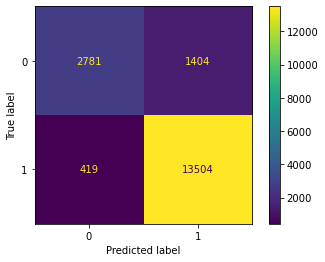

In [59]:
plot_confusion_matrix(lr_pipe, X_train, y_train)

/Users/jillian/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


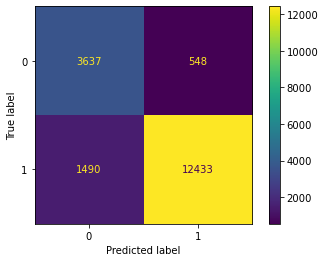

In [60]:
plot_confusion_matrix(lr2_pipe, X_train, y_train)

In [61]:
#comparing confusion matrix w/ smote (lr2) versus confusion matrix w/o smote (lr)

In [62]:
# Show Classification Report
print(classification_report(y_train, lr2_yhat))

              precision    recall  f1-score   support

           0       0.71      0.87      0.78      4185
           1       0.96      0.89      0.92     13923

    accuracy                           0.89     18108
   macro avg       0.83      0.88      0.85     18108
weighted avg       0.90      0.89      0.89     18108



In [63]:
cross_val(lr2_pipe, X_train, y_train, accuracy)

Mean accuracy score:  {0.8565823084586492} .
Median acuracy score:  {0.8578133627829928} .
Standard Deviation in accuracy:  {0.0034112273820527256} .


- Mean accuracy score:  {0.8565823084586492} .
- Median acuracy score:  {0.8578133627829928} .
- Standard Deviation in accuracy:  {0.0034112273820527256} .

In [64]:
#adjusting max_features params

In [65]:
lr3_params = {
    'vect__max_df': (0.5, 0.75, 1.0),
    'vect__max_features': (1500, 2000, 3000), 
    'lr__solver': ('lbfgs', 'saga', 'liblinear'),
    'lr__penalty': ('l2', 'elasticnet'),
    'lr__class_weight': (None, 'balanced')
    }

In [66]:
grid_lr3 = GridSearchCV(lr_pipe, param_grid=lr3_params, cv=5, verbose=3)

In [67]:
#grid_lr3.fit(X_train, y_train)

In [68]:
#best_parameters = grid_lr3.best_params_

#print('Grid Search found the following optimal parameters: ')
#for param_name in sorted(best_parameters.keys()):
    #print('%s: %r' % (param_name, best_parameters[param_name]))

#training_preds = grid_lr3.predict(X_train)
#training_accuracy = accuracy_score(y_train, training_preds)
#training_recall = recall_score(y_train, training_preds, average = None)

#print('Training Accuracy: {:.4}%'.format(training_accuracy * 100))
#print(training_recall)

Grid Search found the following optimal parameters: 
- lr__class_weight: None
- lr__penalty: 'l2'
- lr__solver: 'saga'
- vect__max_df: 0.5
- vect__max_features: 3000
- Training Accuracy: 89.62%
- [0.66332139 0.96624291]

In [69]:
#vect max features of 3000 seems to be optimal

In [70]:
##utilizing current best model as best_model to test out model with Twitter data; will still
#try to tune models

In [128]:
lr3_pipe = Pipeline([
           ('vect', TfidfVectorizer(max_df=.5, max_features=3000)),
           ('lr', LogisticRegression(random_state=42, class_weight=None, solver='saga')),
])


In [129]:
lr3_pipe.fit(X_train, y_train)

Pipeline(steps=[('vect', TfidfVectorizer(max_df=0.5, max_features=3000)),
                ('lr', LogisticRegression(random_state=42, solver='saga'))])

In [130]:
lr3_pipe.score(X_train, y_train)

0.8962337088579634

In [74]:
#trying using ngram_range of 1,2 to see if accuracy improves looking at single words and bigrams; silght improvement (.04%)

In [131]:
lr4_pipe = Pipeline([
           ('vect', TfidfVectorizer(max_df=.5, max_features=3000, ngram_range=(1,2))),
           ('lr', LogisticRegression(random_state=42, class_weight=None, solver='saga')),
])

In [132]:
lr4_pipe.fit(X_train, y_train)

Pipeline(steps=[('vect',
                 TfidfVectorizer(max_df=0.5, max_features=3000,
                                 ngram_range=(1, 2))),
                ('lr', LogisticRegression(random_state=42, solver='saga'))])

In [133]:
lr4_pipe.score(X_train, y_train)

0.8966755025403137

In [134]:
##grid search with ngrams (1,1), (1,2), (2,2)
#try looking at data with no additional stop words removed
##running with max_features of 10 to see top 10 being pulled or try to find top words

In [135]:
#Checking the same parameters utilizing X_train2, y_train2

In [136]:
lr4_pipe.fit(X_train2, y_train2)

Pipeline(steps=[('vect',
                 TfidfVectorizer(max_df=0.5, max_features=3000,
                                 ngram_range=(1, 2))),
                ('lr', LogisticRegression(random_state=42, solver='saga'))])

In [110]:
lr4_pipe.score(X_train2, y_train2)

0.902440371024735

In [111]:
#WOO accuracy increased to above 90%

In [117]:
cross_val(lr4_pipe, X_train, y_train, accuracy)

Mean accuracy score:  {0.8702782910474834} .
Median acuracy score:  {0.8704777685722176} .
Standard Deviation in accuracy:  {0.0007555916171433703} .


In [116]:
cross_val(lr4_pipe, X_train2, y_train2, accuracy)

Mean accuracy score:  {0.8769875052829086} .
Median acuracy score:  {0.8757935412641458} .
Standard Deviation in accuracy:  {0.0028986525899336725} .


In [ ]:
##grid search with ngrams (1,1), (1,2), (2,2)
#try looking at data with no additional stop words removed
##running with max_features of 10 to see top 10 being pulled or try to find top words

In [146]:
lr5_params = {
    'vect__max_df': (0.5, 0.75, 1.0),
    'vect__max_features': (2000, 2500, 3000), 
    'vect__ngram_range': [(1,1), (1,2), (2,2)],
    'lr__solver': ('lbfgs', 'saga'),
    'lr__class_weight': (None, 'balanced')
    }

In [ ]:
#grid search using X_train and y_train

In [154]:
grid_lr5 = GridSearchCV(lr_pipe, param_grid=lr5_params, cv=5, verbose=3, n_jobs=-2)

In [155]:
grid_lr5.fit(X_train, y_train)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


/Users/jillian/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('vect', TfidfVectorizer()),
                                       ('lr',
                                        LogisticRegression(random_state=42))]),
             n_jobs=-2,
             param_grid={'lr__class_weight': (None, 'balanced'),
                         'lr__solver': ('lbfgs', 'saga'),
                         'vect__max_df': (0.5, 0.75, 1.0),
                         'vect__max_features': (2000, 2500, 3000),
                         'vect__ngram_range': [(1, 1), (1, 2), (2, 2)]},
             verbose=3)

In [156]:
grid_lr5.score(X_train, y_train)

0.8956262425447317

In [157]:
best_parameters = grid_lr5.best_params_

print('Grid Search found the following optimal parameters: ')
for param_name in sorted(best_parameters.keys()):
    print('%s: %r' % (param_name, best_parameters[param_name]))

training_preds = grid_lr5.predict(X_train)
training_accuracy = accuracy_score(y_train, training_preds)
training_recall = recall_score(y_train, training_preds, average = None)

print('Training Accuracy: {:.4}%'.format(training_accuracy * 100))
print(training_recall)

Grid Search found the following optimal parameters: 
lr__class_weight: None
lr__solver: 'saga'
vect__max_df: 0.5
vect__max_features: 2500
vect__ngram_range: (1, 1)
Training Accuracy: 89.56%
[0.66117085 0.96609926]


In [161]:
lr5_pipe = Pipeline([
           ('vect', TfidfVectorizer(max_df=.5, max_features=2500, ngram_range=(1,1))),
           ('lr', LogisticRegression(random_state=42, class_weight=None, solver='saga')),
])

In [162]:
lr5_pipe.fit(X_train, y_train)

Pipeline(steps=[('vect', TfidfVectorizer(max_df=0.5, max_features=2500)),
                ('lr', LogisticRegression(random_state=42, solver='saga'))])

In [163]:
cross_val(lr5_pipe, X_train, y_train, accuracy)

Mean accuracy score:  {0.8716037239667802} .
Median acuracy score:  {0.8699613473219215} .
Standard Deviation in accuracy:  {0.002387323014677118} .


In [158]:
grid_lr5.fit(X_train2, y_train2)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


/Users/jillian/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('vect', TfidfVectorizer()),
                                       ('lr',
                                        LogisticRegression(random_state=42))]),
             n_jobs=-2,
             param_grid={'lr__class_weight': (None, 'balanced'),
                         'lr__solver': ('lbfgs', 'saga'),
                         'vect__max_df': (0.5, 0.75, 1.0),
                         'vect__max_features': (2000, 2500, 3000),
                         'vect__ngram_range': [(1, 1), (1, 2), (2, 2)]},
             verbose=3)

In [159]:
grid_lr5.score(X_train2, y_train2)

0.902440371024735

In [168]:
best_parameters = grid_lr5.best_params_

print('Grid Search found the following optimal parameters: ')
for param_name in sorted(best_parameters.keys()):
    print('%s: %r' % (param_name, best_parameters[param_name]))

training_preds = grid_lr5.predict(X_train2)
training_accuracy = accuracy_score(y_train2, training_preds)
training_recall = recall_score(y_train2, training_preds, average = None)

print('Training Accuracy: {:.4}%'.format(training_accuracy * 100))
print(training_recall)

Grid Search found the following optimal parameters: 
lr__class_weight: None
lr__solver: 'saga'
vect__max_df: 0.5
vect__max_features: 3000
vect__ngram_range: (1, 2)
Training Accuracy: 90.24%
[0.68278018 0.96789451]


In [164]:
lr6_pipe = Pipeline([
           ('vect', TfidfVectorizer(max_df=.5, max_features=3000, ngram_range=(1,2))),
           ('lr', LogisticRegression(random_state=42, class_weight=None, solver='saga')),
])

In [165]:
lr6_pipe.fit(X_train2, y_train2)

Pipeline(steps=[('vect',
                 TfidfVectorizer(max_df=0.5, max_features=3000,
                                 ngram_range=(1, 2))),
                ('lr', LogisticRegression(random_state=42, solver='saga'))])

In [167]:
cross_val(lr6_pipe, X_train2, y_train2, accuracy)

Mean accuracy score:  {0.8769875052829086} .
Median acuracy score:  {0.8757935412641458} .
Standard Deviation in accuracy:  {0.0028986525899336725} .


## Grid Searching XGBoost

In [81]:
# Instantiate our default XGB pipeline
XGB_pipe = ImPipeline(steps=[('vect', TfidfVectorizer(max_features=3000)), 
                             ('XGB', XGBClassifier())])

In [82]:
# create our massive grid for the grid search parameters
paramsXGB = {
    'XGB__learning_rate': [0.1, 0.2],
    'XGB__max_depth': range(3, 10, 2),
    'XGB__min_child_weight': range(1, 8, 2),
    'XGB__gamma': [0, .1, .2],
    'XGB__subsample': [.5, .75, 1],
    'vect__ngram_range': [(1,1), (2,2)],
}

In [83]:
grid_XGB = GridSearchCV(XGB_pipe, param_grid=paramsXGB, cv=5, verbose=3, n_jobs=-2)

#Fit grid search object to our training data to check the hyper parameters

In [84]:
#grid_XGB.fit(X_train, y_train)

In [85]:
#grid_XGB.best_params_

- {'XGB__gamma': 0,
- 'XGB__learning_rate': 0.2,
- 'XGB__max_depth': 9,
- 'XGB__min_child_weight': 5,
- 'XGB__subsample': 0.75,
- 'vect__ngram_range': (1, 1)}

In [86]:
#grid_XGB.best_score_

0.8630436967252351

In [87]:
#plot_confusion_matrix(grid_XGB, X_train, y_train);

In [88]:
#print(classification_report(y_train, grid_XGB.predict(X_train)))

In [89]:
    #precision    recall  f1-score   support

        #0       0.89      0.72      0.80      4185
        #1       0.92      0.97      0.95     13923

    #accuracy                           0.91     18108
  # macro avg       0.91      0.85      0.87     18108
#weighted avg       0.91      0.91      0.91     18108


In [120]:
# Instantiate our XGB pipeline with optimal parameters and SMOTE
XGB_pipe2 = ImPipeline(steps=[('vect', TfidfVectorizer(max_features=3000)),
            ('sm', SMOTE(random_state=42)),
           ('XGB', XGBClassifier(gamma=0, learning_rate=.2, max_depth=9, min_child_weight=5, subsample=.75))])

In [121]:
XGB_pipe2.fit(X_train, y_train)

Pipeline(steps=[('vect', TfidfVectorizer(max_features=3000)),
                ('sm', SMOTE(random_state=42)),
                ('XGB',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.2,
                               max_delta_step=0, max_depth=9,
                               min_child_weight=5, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=0, num_parallel_tree=1, random_state=0,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                               subsample=0.75, tree_method='exact',
                               validate_parameters=1, verbosity=None))])

In [122]:
XGB_pipe2.score(X_train, y_train)

0.9101502098519991

In [123]:
cross_val(XGB_pipe2, X_train, y_train, accuracy)

Mean accuracy score:  {0.8563061874021273} .
Median acuracy score:  {0.8544600938967136} .
Standard Deviation in accuracy:  {0.00457228431931814} .


In [ ]:
#Checking the same parameters utilizing X_train2, y_train2

In [124]:
XGB_pipe2.fit(X_train2, y_train2)

Pipeline(steps=[('vect', TfidfVectorizer(max_features=3000)),
                ('sm', SMOTE(random_state=42)),
                ('XGB',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.2,
                               max_delta_step=0, max_depth=9,
                               min_child_weight=5, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=0, num_parallel_tree=1, random_state=0,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                               subsample=0.75, tree_method='exact',
                               validate_parameters=1, verbosity=None))])

In [125]:
XGB_pipe2.score(X_train2, y_train2)

0.9225375441696113

In [126]:
cross_val(XGB_pipe2, X_train2, y_train2, accuracy)

Mean accuracy score:  {0.859871704383294} .
Median acuracy score:  {0.8606127518630969} .
Standard Deviation in accuracy:  {0.004757827751813037} .


In [ ]:
# Instantiate our XGB pipeline with optimal parameters without SMOTE

In [137]:
XGB_pipe3 = ImPipeline(steps=[('vect', TfidfVectorizer(max_features=3000)),
           ('XGB', XGBClassifier(gamma=0, learning_rate=.2, max_depth=9, min_child_weight=5, subsample=.75))])

In [138]:
XGB_pipe3.fit(X_train, y_train)

Pipeline(steps=[('vect', TfidfVectorizer(max_features=3000)),
                ('XGB',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.2,
                               max_delta_step=0, max_depth=9,
                               min_child_weight=5, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=0, num_parallel_tree=1, random_state=0,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                               subsample=0.75, tree_method='exact',
                               validate_parameters=1, verbosity=None))])

In [139]:
XGB_pipe3.score(X_train, y_train)

0.9145681466755026

In [140]:
cross_val(XGB_pipe3, X_train, y_train, accuracy)

Mean accuracy score:  {0.8593436257697331} .
Median acuracy score:  {0.860259596796465} .
Standard Deviation in accuracy:  {0.004225578724882773} .


In [141]:
XGB_pipe3.fit(X_train2, y_train2)

Pipeline(steps=[('vect', TfidfVectorizer(max_features=3000)),
                ('XGB',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.2,
                               max_delta_step=0, max_depth=9,
                               min_child_weight=5, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=0, num_parallel_tree=1, random_state=0,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                               subsample=0.75, tree_method='exact',
                               validate_parameters=1, verbosity=None))])

In [142]:
XGB_pipe3.score(X_train2, y_train2)

0.9314818904593639

In [143]:
cross_val(XGB_pipe3, X_train2, y_train2, accuracy)

Mean accuracy score:  {0.8640121635303502} .
Median acuracy score:  {0.8658199889563777} .
Standard Deviation in accuracy:  {0.005762547254784865} .


In [144]:
#better overall scores with XGBoost, but worse cross-val scores

In [127]:
##grid search with ngrams (1,1), (1,2), (2,2)
#try looking at data with no additional stop words removed
##running with max_features of 10 to see top 10 being pulled or try to find top words

In [170]:
paramsXGB2 = {
    'XGB__learning_rate': [0.1, 0.2],
    'XGB__max_depth': (8, 9, 10),
    'XGB__min_child_weight': range(1, 8, 2),
    'XGB__subsample': [.5, .75, 1],
    'vect__max_features': (2000, 2500, 3000),
    'vect__ngram_range': [(1,1), (1,2), (2,2)],
}

In [171]:
grid_XGB2 = GridSearchCV(XGB_pipe, param_grid=paramsXGB2, cv=3, verbose=3, n_jobs=-2)

#Fit grid search object to X-train, y_train

In [172]:
#grid_XGB2.fit(X_train, y_train)

Fitting 3 folds for each of 648 candidates, totalling 1944 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('vect',
                                        TfidfVectorizer(max_features=3000)),
                                       ('sm', SMOTE(random_state=42)),
                                       ('XGB',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      gamma=0, gpu_id=None,
                                                      importance_type='gain',
                                                      interaction_constraints=None,
                                                      learning_rate=0.2,
                                                      max_delta_step=None,
                                                      max_d...
                                                      reg_alpha=None,
                                                      reg_lambda=None,
                                                      scale_pos_weight=None,
                                                      subsample=0.75,
                                                      tree_method=None,
                                                      validate_parameters=None,
                                                      verbosity=None))]),
             n_jobs=-2,
             param_grid={'XGB__learning_rate': [0.1, 0.2],
                         'XGB__max_depth': (8, 9, 10),
                         'XGB__min_child_weight': range(1, 8, 2),
                         'XGB__subsample': [0.5, 0.75, 1],
                         'vect__max_features': (2000, 2500, 3000),
                         'vect__ngram_range': [(1, 1), (1, 2), (2, 2)]},
             verbose=3)

In [173]:
best_parameters = grid_XGB2.best_params_

print('Grid Search found the following optimal parameters: ')
for param_name in sorted(best_parameters.keys()):
    print('%s: %r' % (param_name, best_parameters[param_name]))

training_preds = grid_XGB2.predict(X_train)
training_accuracy = accuracy_score(y_train, training_preds)
training_recall = recall_score(y_train, training_preds, average = None)

print('Training Accuracy: {:.4}%'.format(training_accuracy * 100))
print(training_recall)

Grid Search found the following optimal parameters: 
XGB__learning_rate: 0.2
XGB__max_depth: 10
XGB__min_child_weight: 7
XGB__subsample: 0.75
vect__max_features: 2500
vect__ngram_range: (1, 1)
Training Accuracy: 90.96%
[0.74384707 0.95941967]


- Grid Search found the following optimal parameters: 
- XGB__learning_rate: 0.2
- XGB__max_depth: 10
- XGB__min_child_weight: 7
- XGB__subsample: 0.75
- vect__max_features: 2500
- vect__ngram_range: (1, 1)
- Training Accuracy: 90.96%
- [0.74384707 0.95941967]

In [184]:
##accidentally ran grid search with SMOTE--noooooo!

In [174]:
XGB_pipe4 = ImPipeline(steps=[('vect', TfidfVectorizer(max_features=2500)),
           ('XGB', XGBClassifier(learning_rate=.2, max_depth=10, min_child_weight=7, subsample=.75))])

In [175]:
XGB_pipe4.fit(X_train, y_train)

Pipeline(steps=[('vect', TfidfVectorizer(max_features=2500)),
                ('XGB',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.2,
                               max_delta_step=0, max_depth=10,
                               min_child_weight=7, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=0, num_parallel_tree=1, random_state=0,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                               subsample=0.75, tree_method='exact',
                               validate_parameters=1, verbosity=None))])

In [178]:
XGB_pipe4.score(X_train, y_train)

0.9141263529931521

In [176]:
cross_val(XGB_pipe4, X_train, y_train, accuracy)

Mean accuracy score:  {0.8602275577872558} .
Median acuracy score:  {0.860850358917725} .
Standard Deviation in accuracy:  {0.003830791737806009} .


In [177]:
#trying same grid search with X_train2, y_train2

In [179]:
#grid_XGB2.fit(X_train2, y_train2)

Fitting 3 folds for each of 648 candidates, totalling 1944 fits


/Users/jillian/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('vect',
                                        TfidfVectorizer(max_features=3000)),
                                       ('sm', SMOTE(random_state=42)),
                                       ('XGB',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      gamma=0, gpu_id=None,
                                                      importance_type='gain',
                                                      interaction_constraints=None,
                                                      learning_rate=0.2,
                                                      max_delta_step=None,
                                                      max_d...
                                                      reg_alpha=None,
                                                      reg_lambda=None,
                                                      scale_pos_weight=None,
                                                      subsample=0.75,
                                                      tree_method=None,
                                                      validate_parameters=None,
                                                      verbosity=None))]),
             n_jobs=-2,
             param_grid={'XGB__learning_rate': [0.1, 0.2],
                         'XGB__max_depth': (8, 9, 10),
                         'XGB__min_child_weight': range(1, 8, 2),
                         'XGB__subsample': [0.5, 0.75, 1],
                         'vect__max_features': (2000, 2500, 3000),
                         'vect__ngram_range': [(1, 1), (1, 2), (2, 2)]},
             verbose=3)

In [185]:
##accidentally ran grid search with SMOTE--nooooo

In [180]:
best_parameters = grid_XGB2.best_params_

print('Grid Search found the following optimal parameters: ')
for param_name in sorted(best_parameters.keys()):
    print('%s: %r' % (param_name, best_parameters[param_name]))

training_preds = grid_XGB2.predict(X_train2)
training_accuracy = accuracy_score(y_train2, training_preds)
training_recall = recall_score(y_train2, training_preds, average = None)

print('Training Accuracy: {:.4}%'.format(training_accuracy * 100))
print(training_recall)

Grid Search found the following optimal parameters: 
XGB__learning_rate: 0.2
XGB__max_depth: 10
XGB__min_child_weight: 3
XGB__subsample: 1
vect__max_features: 3000
vect__ngram_range: (1, 2)
Training Accuracy: 93.97%
[0.81385281 0.97721084]


- Grid Search found the following optimal parameters: 
- XGB__learning_rate: 0.2
- XGB__max_depth: 10
- XGB__min_child_weight: 3
- XGB__subsample: 1
- vect__max_features: 3000
- vect__ngram_range: (1, 2)
- Training Accuracy: 93.97%
- [0.81385281 0.97721084]

In [195]:
#grid_XGB2.best_score_

0.8653930660452439

0.8653930660452439

In [ ]:
#pipe without smote

In [191]:
XGB_pipe6 = ImPipeline(steps=[('vect', TfidfVectorizer(max_features=3000, ngram_range=(1,2))),
           ('XGB', XGBClassifier(learning_rate=.2, max_depth=10, min_child_weight=3, subsample=1))])

In [192]:
XGB_pipe6.fit(X_train2, y_train2)

Pipeline(steps=[('vect',
                 TfidfVectorizer(max_features=3000, ngram_range=(1, 2))),
                ('XGB',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.2,
                               max_delta_step=0, max_depth=10,
                               min_child_weight=3, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=0, num_parallel_tree=1, random_state=0,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                               subsample=1, tree_method='exact',
                               validate_parameters=1, verbosity=None))])

In [193]:
XGB_pipe6.score(X_train2, y_train2)

0.9525728798586572

In [194]:
cross_val(XGB_pipe6, X_train2, y_train2, accuracy)

Mean accuracy score:  {0.8661658070493548} .
Median acuracy score:  {0.8677891250345018} .
Standard Deviation in accuracy:  {0.005732367999867383} .


In [186]:
#pipe with smote

In [187]:
XGB_pipe6 = ImPipeline(steps=[('vect', TfidfVectorizer(max_features=3000, ngram_range=(1,2))),
                              ('sm', SMOTE(random_state=42)),
                               ('XGB', XGBClassifier(learning_rate=.2, max_depth=10, min_child_weight=3, subsample=1))])



In [188]:
XGB_pipe6.fit(X_train2, y_train2)

Pipeline(steps=[('vect',
                 TfidfVectorizer(max_features=3000, ngram_range=(1, 2))),
                ('sm', SMOTE(random_state=42)),
                ('XGB',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.2,
                               max_delta_step=0, max_depth=10,
                               min_child_weight=3, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=0, num_parallel_tree=1, random_state=0,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                               subsample=1, tree_method='exact',
                               validate_parameters=1, verbosity=None))])

In [189]:
XGB_pipe6.score(X_train2, y_train2)

0.939708480565371

In [190]:
cross_val(XGB_pipe6, X_train2, y_train2, accuracy)

Mean accuracy score:  {0.8643988427210474} .
Median acuracy score:  {0.8666850676235164} .
Standard Deviation in accuracy:  {0.006371064109466086} .


In [197]:
##could try reducing max_features

In [198]:
##utilize SMOTEN instead of SMOTE

## Grid Searching Random Forest Classifier

In [205]:
# Create our random forest pipeline to incorporate vectorizer, use default hyperparameters
rfc_pipe = Pipeline(steps=[('vect', TfidfVectorizer()),
                           ('rfc', RandomForestClassifier(random_state=42))])

In [206]:
# Fit our random forest classifier to the training data
rfc_pipe.fit(X_train, y_train)

Pipeline(steps=[('vect', TfidfVectorizer()),
                ('rfc', RandomForestClassifier(random_state=42))])

In [207]:
# Calculate initial accuracy score of random forest with default hyperparameters
rfc_pipe.score(X_train, y_train)

1.0

In [208]:
cross_val(rfc_pipe, X_train, y_train, accuracy)

Mean accuracy score:  {0.8360394172834671} .
Median acuracy score:  {0.8367854183927091} .
Standard Deviation in accuracy:  {0.0023055779416382705} .


In [209]:
rfc_pipe.fit(X_train2, y_train2)

Pipeline(steps=[('vect', TfidfVectorizer()),
                ('rfc', RandomForestClassifier(random_state=42))])

In [210]:
cross_val(rfc_pipe, X_train2, y_train2, accuracy)

Mean accuracy score:  {0.8277383450996327} .
Median acuracy score:  {0.8277194919933738} .
Standard Deviation in accuracy:  {0.0014702116441135892} .


In [216]:
# create our massive grid for the grid search parameters
params = {'rfc__n_estimators': [100, 150, 200],
           'rfc__max_depth': [15, 20, 25],
           'rfc__max_features': ['sqrt', 'log2'],
           'rfc__min_samples_leaf': [25, 50],
           'rfc__min_impurity_decrease': [0, 0.05, 0.1],
           'rfc__criterion': ['gini', 'entropy'],
            'vect__max_features': (2500, 3000),
            'vect__ngram_range': [(1,1), (1,2)],}

# set up GridSearchCV object
grid_rfc = GridSearchCV(rfc_pipe, param_grid=params, cv=3, n_jobs=-2, verbose=3)

In [217]:
# Fit the grid search object to X_train, y_train
grid_rfc.fit(X_train, y_train)

Fitting 3 folds for each of 864 candidates, totalling 2592 fits


/Users/jillian/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('vect', TfidfVectorizer()),
                                       ('rfc',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-2,
             param_grid={'rfc__criterion': ['gini', 'entropy'],
                         'rfc__max_depth': [15, 20, 25],
                         'rfc__max_features': ['sqrt', 'log2'],
                         'rfc__min_impurity_decrease': [0, 0.05, 0.1],
                         'rfc__min_samples_leaf': [25, 50],
                         'rfc__n_estimators': [100, 150, 200],
                         'vect__max_features': (2500, 3000),
                         'vect__ngram_range': [(1, 1), (1, 2)]},
             verbose=3)

In [219]:
grid_rfc.score(X_train, y_train)

0.7950077313894411

In [218]:
best_parameters = grid_rfc.best_params_

print('Grid Search found the following optimal parameters: ')
for param_name in sorted(best_parameters.keys()):
    print('%s: %r' % (param_name, best_parameters[param_name]))

training_preds = grid_rfc.predict(X_train)
training_accuracy = accuracy_score(y_train, training_preds)
training_recall = recall_score(y_train, training_preds, average = None)

print('Training Accuracy: {:.4}%'.format(training_accuracy * 100))
print(training_recall)

Grid Search found the following optimal parameters: 
rfc__criterion: 'gini'
rfc__max_depth: 25
rfc__max_features: 'sqrt'
rfc__min_impurity_decrease: 0
rfc__min_samples_leaf: 25
rfc__n_estimators: 150
vect__max_features: 2500
vect__ngram_range: (1, 2)
Training Accuracy: 79.5%
[0.12043011 0.99777347]


In [220]:
# Fit the grid search object to X_train, y_train
grid_rfc.fit(X_train2, y_train2)

Fitting 3 folds for each of 864 candidates, totalling 2592 fits


/Users/jillian/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('vect', TfidfVectorizer()),
                                       ('rfc',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-2,
             param_grid={'rfc__criterion': ['gini', 'entropy'],
                         'rfc__max_depth': [15, 20, 25],
                         'rfc__max_features': ['sqrt', 'log2'],
                         'rfc__min_impurity_decrease': [0, 0.05, 0.1],
                         'rfc__min_samples_leaf': [25, 50],
                         'rfc__n_estimators': [100, 150, 200],
                         'vect__max_features': (2500, 3000),
                         'vect__ngram_range': [(1, 1), (1, 2)]},
             verbose=3)

In [221]:
grid_rfc.score(X_train2, y_train2)

0.807310070671378

In [225]:
best_parameters = grid_rfc.best_params_

print('Grid Search found the following optimal parameters: ')
for param_name in sorted(best_parameters.keys()):
    print('%s: %r' % (param_name, best_parameters[param_name]))

training_preds = grid_rfc.predict(X_train2)
training_accuracy = accuracy_score(y_train2, training_preds)
training_recall = recall_score(y_train2, training_preds, average = None)

print('Training Accuracy: {:.4}%'.format(training_accuracy * 100))
print(training_recall)

Grid Search found the following optimal parameters: 
rfc__criterion: 'gini'
rfc__max_depth: 25
rfc__max_features: 'sqrt'
rfc__min_impurity_decrease: 0
rfc__min_samples_leaf: 25
rfc__n_estimators: 100
vect__max_features: 2500
vect__ngram_range: (1, 2)
Training Accuracy: 80.73%
[0.17267917 0.9964168 ]


In [223]:
# create our massive grid for the grid search parameters
params2 = {'rfc__n_estimators': [125, 150, 175],
           'rfc__max_depth': [25, 50, 75],
           'rfc__max_features': ['sqrt', 'log2'],
           'rfc__min_samples_leaf': [10, 17, 25],
           'rfc__min_impurity_decrease': [0, 0.05],
           'rfc__criterion': ['gini', 'entropy'],
            'vect__max_features': (2500, 3000),
            'vect__ngram_range': [(1,1), (1,2)],}

# set up GridSearchCV object
grid_rfc2 = GridSearchCV(rfc_pipe, param_grid=params2, cv=3, n_jobs=-2, verbose=3)

In [224]:
# Fit the grid search object to X_train, y_train
grid_rfc2.fit(X_train, y_train)

Fitting 3 folds for each of 864 candidates, totalling 2592 fits


/Users/jillian/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('vect', TfidfVectorizer()),
                                       ('rfc',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-2,
             param_grid={'rfc__criterion': ['gini', 'entropy'],
                         'rfc__max_depth': [25, 50, 75],
                         'rfc__max_features': ['sqrt', 'log2'],
                         'rfc__min_impurity_decrease': [0, 0.05],
                         'rfc__min_samples_leaf': [10, 17, 25],
                         'rfc__n_estimators': [125, 150, 175],
                         'vect__max_features': (2500, 3000),
                         'vect__ngram_range': [(1, 1), (1, 2)]},
             verbose=3)

In [237]:
best_parameters = grid_rfc2.best_params_

print('Grid Search found the following optimal parameters: ')
for param_name in sorted(best_parameters.keys()):
    print('%s: %r' % (param_name, best_parameters[param_name]))

training_preds = grid_rfc2.predict(X_train)
training_accuracy = accuracy_score(y_train, training_preds)
training_recall = recall_score(y_train, training_preds, average = None)

print('Training Accuracy: {:.4}%'.format(training_accuracy * 100))
print(training_recall)

Grid Search found the following optimal parameters: 
rfc__criterion: 'gini'
rfc__max_depth: 75
rfc__max_features: 'sqrt'
rfc__min_impurity_decrease: 0
rfc__min_samples_leaf: 10
rfc__n_estimators: 150
vect__max_features: 2500
vect__ngram_range: (1, 2)
Training Accuracy: 82.57%
[0.28434886 0.9884364 ]


In [227]:
# Fit the grid search object to X_train2, y_train
grid_rfc2.fit(X_train2, y_train2)

Fitting 3 folds for each of 864 candidates, totalling 2592 fits


/Users/jillian/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('vect', TfidfVectorizer()),
                                       ('rfc',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-2,
             param_grid={'rfc__criterion': ['gini', 'entropy'],
                         'rfc__max_depth': [25, 50, 75],
                         'rfc__max_features': ['sqrt', 'log2'],
                         'rfc__min_impurity_decrease': [0, 0.05],
                         'rfc__min_samples_leaf': [10, 17, 25],
                         'rfc__n_estimators': [125, 150, 175],
                         'vect__max_features': (2500, 3000),
                         'vect__ngram_range': [(1, 1), (1, 2)]},
             verbose=3)

In [236]:
best_parameters = grid_rfc2.best_params_

print('Grid Search found the following optimal parameters: ')
for param_name in sorted(best_parameters.keys()):
    print('%s: %r' % (param_name, best_parameters[param_name]))

training_preds = grid_rfc2.predict(X_train2)
training_accuracy = accuracy_score(y_train2, training_preds)
training_recall = recall_score(y_train2, training_preds, average = None)

print('Training Accuracy: {:.4}%'.format(training_accuracy * 100))
print(training_recall)

Grid Search found the following optimal parameters: 
rfc__criterion: 'gini'
rfc__max_depth: 75
rfc__max_features: 'sqrt'
rfc__min_impurity_decrease: 0
rfc__min_samples_leaf: 10
rfc__n_estimators: 150
vect__max_features: 2500
vect__ngram_range: (1, 2)
Training Accuracy: 85.97%
[0.42568543 0.9890354 ]


In [231]:
# create our massive grid for the grid search parameters
params3 = {'rfc__n_estimators': [200, 250, 300],
           'rfc__max_depth': [25, 50, 75, 100],
           'rfc__min_samples_leaf': [2, 5, 10],
           'rfc__min_impurity_decrease': [0, 0.05],
           'rfc__criterion': ['gini', 'entropy'],
            'vect__max_features': (2500, 3000),
            'vect__ngram_range': [(1,1), (1,2)],}

# set up GridSearchCV object
grid_rfc3 = GridSearchCV(rfc_pipe, param_grid=params3, cv=3, n_jobs=-2, verbose=3)

In [232]:
# Fit the grid search object to X_train, y_train
grid_rfc3.fit(X_train, y_train)

Fitting 3 folds for each of 576 candidates, totalling 1728 fits


/Users/jillian/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('vect', TfidfVectorizer()),
                                       ('rfc',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-2,
             param_grid={'rfc__criterion': ['gini', 'entropy'],
                         'rfc__max_depth': [25, 50, 75, 100],
                         'rfc__min_impurity_decrease': [0, 0.05],
                         'rfc__min_samples_leaf': [2, 5, 10],
                         'rfc__n_estimators': [200, 250, 300],
                         'vect__max_features': (2500, 3000),
                         'vect__ngram_range': [(1, 1), (1, 2)]},
             verbose=3)

In [238]:
best_parameters = grid_rfc3.best_params_

print('Grid Search found the following optimal parameters: ')
for param_name in sorted(best_parameters.keys()):
    print('%s: %r' % (param_name, best_parameters[param_name]))

training_preds = grid_rfc3.predict(X_train)
training_accuracy = accuracy_score(y_train, training_preds)
training_recall = recall_score(y_train, training_preds, average = None)

print('Training Accuracy: {:.4}%'.format(training_accuracy * 100))
print(training_recall)

Grid Search found the following optimal parameters: 
rfc__criterion: 'gini'
rfc__max_depth: 100
rfc__min_impurity_decrease: 0
rfc__min_samples_leaf: 2
rfc__n_estimators: 300
vect__max_features: 2500
vect__ngram_range: (1, 2)
Training Accuracy: 87.25%
[0.49127838 0.98707175]


In [234]:
grid_rfc3.fit(X_train2, y_train2)

Fitting 3 folds for each of 576 candidates, totalling 1728 fits


/Users/jillian/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('vect', TfidfVectorizer()),
                                       ('rfc',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-2,
             param_grid={'rfc__criterion': ['gini', 'entropy'],
                         'rfc__max_depth': [25, 50, 75, 100],
                         'rfc__min_impurity_decrease': [0, 0.05],
                         'rfc__min_samples_leaf': [2, 5, 10],
                         'rfc__n_estimators': [200, 250, 300],
                         'vect__max_features': (2500, 3000),
                         'vect__ngram_range': [(1, 1), (1, 2)]},
             verbose=3)

In [239]:
best_parameters = grid_rfc3.best_params_

print('Grid Search found the following optimal parameters: ')
for param_name in sorted(best_parameters.keys()):
    print('%s: %r' % (param_name, best_parameters[param_name]))

training_preds = grid_rfc3.predict(X_train2)
training_accuracy = accuracy_score(y_train2, training_preds)
training_recall = recall_score(y_train2, training_preds, average = None)

print('Training Accuracy: {:.4}%'.format(training_accuracy * 100))
print(training_recall)

Grid Search found the following optimal parameters: 
rfc__criterion: 'gini'
rfc__max_depth: 100
rfc__min_impurity_decrease: 0
rfc__min_samples_leaf: 2
rfc__n_estimators: 300
vect__max_features: 2500
vect__ngram_range: (1, 2)
Training Accuracy: 96.2%
[0.83886484 0.99863838]


# Pickling Model

Playing around with pickling using current "Best Model"; Note: DO NOT NEED TO TEST TWEETS

In [91]:
# save the model to disk
#filename = 'finalized_model.sav'
#pickle.dump(best_model, open(filename, 'wb'))

In [92]:
#loaded_model = pickle.load(open(filename, 'rb'))
#result = loaded_model.score(X_test, y_test)
#print(result)